# 클래스


## 1. plan 클래스 

역할 : 최적의 경로를 구하자.
책임 : 
1. make_heuristic : -> 휴리스틱 배열 만들기
2. astar : A* 알고리즘, -> 경로 추출
3. smooth : 스무딩 알고리즘, (경로)->(경로)

## 2. robot 클래스

역할 : 로봇을 정의 후 motion(이동) 하자
책임 :
1. set : 로봇의 인자를 setter
2. set_noise : 노이즈 인자를 setter 
3. check_collision : 충돌 감지, 벽과(0.5) 정도 거리인지 
4. check_goal : 목적지 도착 (유클리드-0.2 이하인지) 
5. move :
6. sense : 
7. measurement_prob : 실제 로봇의 liklihood을 구한다.
9. ```__repr__``` 

## 3. particles 클래스

역할 : 
책임 :

## entry 코드

run : 
main : 




In [190]:
from math import *
import random


# don't change the noise paameters

# 노이즈 값, 스티어링시 애러
# 가우시안 분포중 - 표준편차 애러,
steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3 


class plan:

    # --------
    # 역할 : 최적의 경로를 구하자.
    # init: 
    #    creates an empty plan
    #

    def __init__(self, grid, init, goal, cost = 1):
        self.cost = cost
        self.grid = grid
        self.init = init
        self.goal = goal
        self.make_heuristic(grid, goal, self.cost)
        self.path = []
        self.spath = []

    # --------
    #
    # make heuristic function for a grid
    # 결과 : self.heuristic 배열이 채워진다.
        
    def make_heuristic(self, grid, goal, cost):
        self.heuristic = [[0 for row in range(len(grid[0]))] 
                          for col in range(len(grid))]
        for i in range(len(self.grid)):    
            for j in range(len(self.grid[0])):
                self.heuristic[i][j] = abs(i - self.goal[0]) + \
                    abs(j - self.goal[1])



    # ------------------------------------------------
    # 
    # A* for searching a path to the goal
    #
    # return path (경로)

    def astar(self):
        if self.heuristic == []:
            raise ValueError("Heuristic must be defined to run A*")

        # internal motion parameters
        delta = [[-1,  0], # go up
                 [ 0,  -1], # go left
                 [ 1,  0], # go down
                 [ 0,  1]] # do right

        # open list elements are of the type: [f, g, h, x, y]

        closed = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]
        action = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]

        closed[self.init[0]][self.init[1]] = 1

        x = self.init[0]
        y = self.init[1]
        h = self.heuristic[x][y]
        g = 0
        f = g + h

        open = [[f, g, h, x, y]]

        found  = False # flag that is set when search complete
        resign = False # flag set if we can't find expand
        count  = 0

        while not found and not resign:
            # check if we still have elements on the open list
            if len(open) == 0:
                resign = True
                print('###### Search terminated without success')
            else:
                # remove node from list
                open.sort()
                open.reverse()
                next = open.pop()
                x = next[3]
                y = next[4]
                g = next[1]

            # check if we are done

            if x == goal[0] and y == goal[1]:
                found = True
                # print '###### A* search successful'
            else:
                # expand winning element and add to new open list
                for i in range(len(delta)):
                    x2 = x + delta[i][0]
                    y2 = y + delta[i][1]
                    if x2 >= 0 and x2 < len(self.grid) and y2 >= 0 \
                            and y2 < len(self.grid[0]):
                        if closed[x2][y2] == 0 and self.grid[x2][y2] == 0:
                            g2 = g + self.cost
                            h2 = self.heuristic[x2][y2]
                            f2 = g2 + h2
                            open.append([f2, g2, h2, x2, y2])
                            closed[x2][y2] = 1
                            action[x2][y2] = i
            count += 1
        # extract the path
        # 실제 path을 구하는 로직( action을 순회하며, goal -> 현재 위치, footprint )
        invpath = []
        x = self.goal[0]
        y = self.goal[1]
        invpath.append([x, y])
        while x != self.init[0] or y != self.init[1]:
            x2 = x - delta[action[x][y]][0]
            y2 = y - delta[action[x][y]][1]
            x = x2
            y = y2
            invpath.append([x, y])
        self.path = []
        for i in range(len(invpath)):
            self.path.append(invpath[len(invpath) - 1 - i])

    # ------------------------------------------------
    # 
    # this is the smoothing function
    #
    # 스무딩 알고리즘
    # tolerance - 어느정도 수렴하면 더이상 변하지 않게끔, while문 나가게 한다.
    # return spath (smooth - 경로)
    def smooth(self, weight_data = 0.1, weight_smooth = 0.1, 
               tolerance = 0.000001):
        if self.path == []:
            raise ValueError("Run A* first before smoothing path")

        self.spath = [[0 for row in range(len(self.path[0]))] \
                           for col in range(len(self.path))]
        for i in range(len(self.path)):
            for j in range(len(self.path[0])):
                self.spath[i][j] = self.path[i][j]

        change = tolerance
        while change >= tolerance:
            change = 0.0
            for i in range(1, len(self.path)-1):
                for j in range(len(self.path[0])):
                    aux = self.spath[i][j]
                    # 원본 경로로 만들게끔 하는 로직 (경사하강 - 1 )
                    self.spath[i][j] += weight_data * \
                        (self.path[i][j] - self.spath[i][j])
                    # 최대한 스무스 하게 만드는( 응집? 하려는) 로직 (경사하강 - 2)
                    self.spath[i][j] += weight_smooth * \
                        (self.spath[i-1][j] + self.spath[i+1][j] 
                         - (2.0 * self.spath[i][j]))
                    # 경로 양끝단은 정확하게 측정하기 위한 로직 ( optional 테크닉 )
                    if i >= 2:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i-1][j] - self.spath[i-2][j] 
                             - self.spath[i][j])
                    if i <= len(self.path) - 3:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i+1][j] - self.spath[i+2][j] 
                             - self.spath[i][j])
                
            change += abs(aux - self.spath[i][j])


            

In [191]:

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #   creates robot and initializes location/orientation to 0, 0, 0
    #
    def __init__(self, length = 0.5):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0 # 수평 기준 얼만큼 회전 되었나,
        self.length = length
        self.steering_noise    = 0.0 # 핸들링 노이즈
        self.distance_noise    = 0.0 # 모션(이동) 노이즈
        self.measurement_noise = 0.0 # 센싱 노이즈
        self.num_collisions    = 0 # 로봇이 부딪치는 횟수
        self.num_steps         = 0 # 몇번만에 도착하는지
    
    # setter section
    # --------
    # set: 
    #   sets a robot coordinate(위치)
    #
    def set(self, new_x, new_y, new_orientation):
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #   sets the noise parameters
    #
    def set_noise(self, new_s_noise, new_d_noise, new_m_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise     = float(new_s_noise)
        self.distance_noise    = float(new_d_noise)
        self.measurement_noise = float(new_m_noise)

    # --------
    # check: 
    #    checks of the robot pose collides with an obstacle, or
    # is too far outside the plane
    # 벽에(grid 값이=1 인 ), 0.5 정도만 들어가도 부딪혔다고 판단한다.
    def check_collision(self, grid):
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 1:
                    dist = sqrt((self.x - float(i)) ** 2 + 
                                (self.y - float(j)) ** 2)
                    if dist < 0.5:
                        self.num_collisions += 1
                        return False
        return True
    
    # 로봇이 goal 에 도착 ? ( 유클리드 거리 0.2 보다 이하면 도착 판단 )
    def check_goal(self, goal, threshold = 0.2):
        dist =  sqrt((float(goal[0]) - self.x) ** 2 + (float(goal[1]) - self.y) ** 2)
        return dist < threshold
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative
    #
    # max_steering_angle : 핸들의 최대 각도 
    def move(self, grid, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        # max_steering_angle : 핸들의 최대 각도 처리
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        res = robot()
        res.length            = self.length
        res.steering_noise    = self.steering_noise
        res.distance_noise    = self.distance_noise
        res.measurement_noise = self.measurement_noise
        res.num_collisions    = self.num_collisions
        res.num_steps         = self.num_steps + 1

        # apply noise
        # eg)
        # - 30도 꺽어라(steering) + 애러(steering_noise) > 31.1도 
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        # 그 다음 위치+각도 => x,y,ori
        if abs(turn) < tolerance:
            # approximate by straight line motion
            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)

            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)
        # check for collision
        # res.check_collision(grid)
        return res

    # --------
    # sense: 
    #    자기의 위치를 알고 싶은데, 노이즈값을 더해준다.(gauss에 의해)

    def sense(self):
        return [random.gauss(self.x, self.measurement_noise),
                random.gauss(self.y, self.measurement_noise)]

    # --------
    # measurement_prob
    #    computes the probability of a measurement
    # 
    #  실제 로봇의 liklihood을 구한다.
    def measurement_prob(self, measurement):
        # compute errors
        error_x = measurement[0] - self.x
        error_y = measurement[1] - self.y

        # calculate Gaussian
        error = exp(- (error_x ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))
        error *= exp(- (error_y ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))

        return error

    def __repr__(self):
        # return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
        return '[%.5f, %.5f]'  % (self.x, self.y)



In [192]:

# ------------------------------------------------
# 
# this is the particle filter class
#
# 파티클 100개, 1000개 등 파티클 필터를 만드는 클래스
class particles:
    # --------
    # init: 
    #   creates particle set with given initial position
    #
    # 노이즈 값(방향(조타), 이동, 센싱), 파티클 수 N
    def __init__(self, x, y, theta, 
                 steering_noise, distance_noise, measurement_noise, N = 100):
        self.N = N
        self.steering_noise    = steering_noise
        self.distance_noise    = distance_noise
        self.measurement_noise = measurement_noise
        
        self.data = []
        for i in range(self.N):
            # 로봇 100개를 만든다.(파티클)
            r = robot()
            r.set(x, y, theta)
            r.set_noise(steering_noise, distance_noise, measurement_noise)
            self.data.append(r)

    # --------
    #
    # extract position from a particle set
    # 
    def get_position(self):
        x = 0.0
        y = 0.0
        orientation = 0.0
        for i in range(self.N):
            x += self.data[i].x
            y += self.data[i].y
            # orientation is tricky because it is cyclic. By normalizing
            # around the first particle we are somewhat more robust to
            # the 0=2pi problem
            # 첫번째 파티클(로봇)의 각도를 기준으로 다른 파티클(로봇)의 각도를 normalization 함
            orientation += (((self.data[i].orientation
                              - self.data[0].orientation + pi) % (2.0 * pi)) 
                            + self.data[0].orientation - pi)
        return [x / self.N, y / self.N, orientation / self.N]

    # --------
    #
    # motion of the particles
    # 
    def move(self, grid, steer, speed):
        newdata = []
        for i in range(self.N):
            r = self.data[i].move(grid, steer, speed)
            newdata.append(r)
        self.data = newdata

    # --------
    #
    # sensing and resampling
    # 
    def sense(self, Z):
        w = []
        for i in range(self.N):
            w.append(self.data[i].measurement_prob(Z))
        # resampling (careful, this is using shallow copy)
        p3 = []
        index = int(random.random() * self.N)
        beta = 0.0
        mw = max(w)
        for i in range(self.N): # N(100)개를 다시 뽑는다.
            beta += random.random() * 2.0 * mw
            while beta > w[index]: # w가 큰값이 리샘플링 되도록 한다.
                beta -= w[index]
                index = (index + 1) % self.N
            p3.append(self.data[index])
        self.data = p3



===run===
[True, 0, 151]
Goal:  [4, 5]
Last location:  [3.7144803492603717, 4.998753750451985]


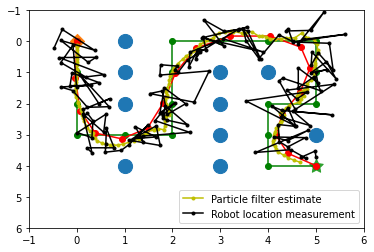

[True, 0, 151]

In [193]:

# --------
#
# run:  runs control program for the robot
# @Params grid, goal, path.spath, [p_gain, d_gain]


def run(grid, goal, spath, params, printflag = False, speed = 0.1, timeout = 1000):

    myrobot = robot() # robot class 
    myrobot.set(0., 0., 0.)
    myrobot.set_noise(steering_noise, distance_noise, measurement_noise)
    # Particles class
    filter = particles(myrobot.x, myrobot.y, myrobot.orientation,
                       steering_noise, distance_noise, measurement_noise)

    cte  = 0.0
    err  = 0.0
    N    = 0

    index = 0 # index into the path
    trail_sense=[]
    trail_move=[]
    
    while not myrobot.check_goal(goal) and N < timeout:
        diff_cte = - cte
        # ----------------------------------------
        # compute the CTE

        # start with the present robot estimate
        estimate = filter.get_position()
        ### ENTER CODE HERE
        while index+1<len(spath):
        # while index+1>=len(spath):
        #     index -= 1
            deltaX=spath[index+1][0]-spath[index][0]
            deltaY=spath[index+1][1]-spath[index][1]
            Rx=estimate[0]-spath[index][0]
            Ry=estimate[1]-spath[index][1]

            try:
                proju=(Rx*deltaX+Ry*deltaY)/(deltaX**2+deltaY**2)
            except OverflowError:
                print("### Overflow Error ###")
                return [False, 0, 0]

            proju=(Rx*deltaX+Ry*deltaY)/(deltaX**2+deltaY**2)
            cte=(Ry*deltaX-Rx*deltaY)/(deltaX**2+deltaY**2)
            if proju>1.0:
                index += 1
            else:
                break
        # ----------------------------------------

        diff_cte += cte
        steer = - params[0] * cte - params[1] * diff_cte 
        myrobot = myrobot.move(grid, steer, speed)
        filter.move(grid, steer, speed)

        Z = myrobot.sense()
        filter.sense(Z)
        guessP=filter.get_position()
        # sense => move 
        trail_sense.append([guessP[0],guessP[1]])
        trail_move.append([Z[0],Z[1]])

        if not myrobot.check_collision(grid):
            print('##### Collision ####')

        err += (cte ** 2)
        N += 1

        if printflag:
            print(myrobot, cte, index, u)


    return [myrobot.check_goal(goal), myrobot.num_collisions, myrobot.num_steps, trail_sense,trail_move]

# ------------------------------------------------
# 
# this is our main routine
#

import numpy as np 
import matplotlib.pyplot as plt 

def main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
     weight_data, weight_smooth, p_gain, d_gain):

    path = plan(grid, init, goal)
    path.astar()
    path.smooth(weight_data, weight_smooth)
    # path.path # - init -> goal 경로 
    # path.spath # - init -> goal smoothed 경로 (후처리되었음)
    checkgoal, collisions, steps, trail_sense, trail_move= run(grid, goal, path.spath, [p_gain, d_gain])
    print("===run===")
    # 도착 여부 , 충돌 횟수, 스탭 ?? 
    print([checkgoal, collisions, steps]) # [True, 7, 266]
    # ✅ trail_sense -> 파티클 필터
    # ✅ trail_move -> 모션(이동)

    map_grid=[]
    Nr=len(grid)
    Nc=len(grid[0])
    for i in range(Nr):
        for j in range(Nc):
            if grid[i][j]==1:
                map_grid.append([j,i])
    map_grid=np.asarray(map_grid)
    # 장애물 벽을 그려준다.
    plt.scatter(map_grid[:,0], map_grid[:,1],s=200)

    map_path=np.asarray(path.path)
    map_spath=np.asarray(path.spath)
    # plt.plot , plt.scatter

    plt.plot(map_path[:,1],map_path[:,0],'go-')    # 초록색 점+선 - path
    plt.plot(map_spath[:,1],map_spath[:,0],'ro-')  # 빨간색 선 - spath ( 스무딩 )
    
    plt.scatter(init[1],init[0],s=100,marker="D") # 시작점을 마킹
    plt.scatter(goal[1],goal[0],s=200,marker=(5,1)) # 도착점을 마킹


    print('Goal: ',goal) # Goal:  [4, 5]
    print('Last location: ',trail_move[-1]) # Last location:  [3.4889064686559434, 5.1075210244761715]

    map_trail_sense=np.asarray(trail_sense)
    map_trail_move=np.asarray(trail_move)

    # ✅ 파티클 필터의 trail 
    plt.plot(map_trail_sense[:,1],map_trail_sense[:,0],'y.-', label='Particle filter estimate')
    # ✅ 로봇의 로컬라이즈
    plt.plot(map_trail_move[:,1],map_trail_move[:,0],'k.-', label='Robot location measurement')


    plt.legend(loc='lower right')
    plt.xlim(-1,6)
    plt.ylim(-1,6)
    plt.gca().invert_yaxis()
    plt.show()

    return [checkgoal, collisions, steps]


# ------------------------------------------------
# input data and parameters
# grid format:
#   0 = navigable space,  1 = occupied space

grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0]]


init = [0, 0]
goal = [len(grid)-1, len(grid[0])-1]


steering_noise    = 0.1 # 
distance_noise    = 0.03
measurement_noise = 0.3

weight_data       = 0.1 # 
weight_smooth     = 0.2 #
p_gain            = 2.0 # P : 목적지 까지의 애러에 비례해서 steering 를 조정  
d_gain            = 6.0 # D : 애러가 0 이 될때까지 계속 신호가 들어옴

    
main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
           weight_data, weight_smooth, p_gain, d_gain)

